In [2]:
import pickle 
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
from pyparsing import Word, alphas, Literal, Combine
from src.evaluation.parser import extract_answer, strip_string, parse_ground_truth
from src.evaluation.grader import math_equal_process
from src.utils import load_jsonl
from tqdm import tqdm 
import matplotlib.pyplot as plt


In [3]:
def load_pkl(cache_file_path: str = None):
    with open(cache_file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

def load_pkls(cache_file_paths: List[str] = None):
    data = None 
    for cache_file_path in cache_file_paths:
        print("loading file: ", cache_file_path)
        with open(cache_file_path, 'rb') as f:
            loaded_data = pickle.load(f)
        
        if data is None:
            data = loaded_data.copy()
        else:
            for k in data.keys():
                data[k].extend(loaded_data[k]) 
    return data

In [4]:
pkls = [
    "/root/llm_inference_boilerplate_code/cache/math_0_2500_qwen2.5-math-7b-instruct.pkl",
    "/root/llm_inference_boilerplate_code/cache/math_2500_5000_qwen2.5-math-7b-instruct.pkl"
]
data = load_pkls(pkls)


gt_path = "../../data/math/test.jsonl"
gt_samples = list(load_jsonl(gt_path))

loading file:  /root/llm_inference_boilerplate_code/cache/math_0_2500_qwen2.5-math-7b-instruct.pkl
loading file:  /root/llm_inference_boilerplate_code/cache/math_2500_5000_qwen2.5-math-7b-instruct.pkl


In [39]:
topk_level = 3
# qid=2
num_token_list = []
num_shy_token_list = []
ratios = []
for qid in range(len(data['responses'])):
    num_tokens = 0
    num_shy_tokens = 0
    for time_step in range(data['topk_probs'][qid].shape[0]):
        if data['topk_probs'][qid][time_step][0] < 0.85:
            num_shy_tokens += 1
        num_tokens += 1
        if data['topk_tokens'][qid][time_step][0] == "<|im_end|>":
                break
            
    num_token_list.append(num_tokens)
    num_shy_token_list.append(num_shy_tokens)
    ratios.append(num_shy_tokens / num_tokens)
        

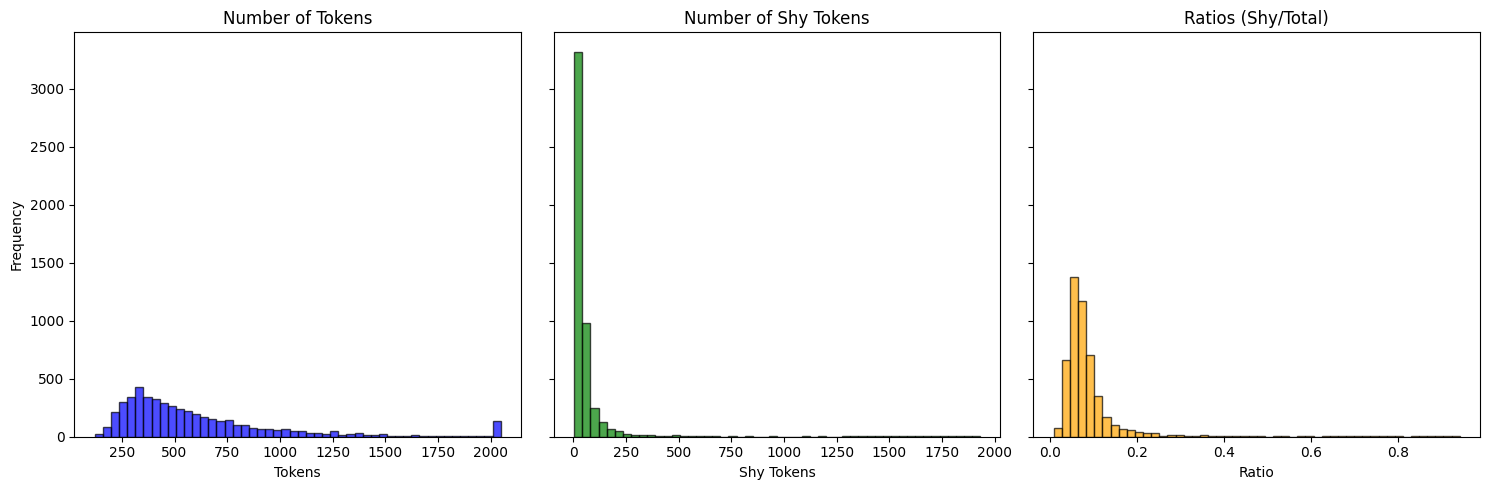

In [30]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # 1 row, 3 columns

# Plot histograms
axes[0].hist(num_token_list, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title("Number of Tokens")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Frequency")

axes[1].hist(num_shy_token_list, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title("Number of Shy Tokens")
axes[1].set_xlabel("Shy Tokens")

axes[2].hist(ratios, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title("Ratios (Shy/Total)")
axes[2].set_xlabel("Ratio")

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

In [69]:
for low, high in zip(np.arange(0, 0.9, 0.1), np.arange(0.1, 1, 0.1)):
    low = round(low, 1)
    high = round(high, 1)
    filtered_samples = [
        (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
        if low <= ratio <= high and correct
    ]

    samples = [
        (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
        if low <= ratio <= high
    ]
    print(f'range [{low},{high}]: {len(filtered_samples)}/{len(samples)} = {len(filtered_samples)/len(samples)}')

range [0.0,0.1]: 3914/4377 = 0.8942197852410326
range [0.1,0.2]: 236/470 = 0.502127659574468
range [0.2,0.3]: 22/60 = 0.36666666666666664
range [0.3,0.4]: 6/21 = 0.2857142857142857
range [0.4,0.5]: 0/11 = 0.0
range [0.5,0.6]: 0/5 = 0.0
range [0.6,0.7]: 0/20 = 0.0
range [0.7,0.8]: 0/21 = 0.0
range [0.8,0.9]: 1/14 = 0.07142857142857142


In [31]:
data['correctness'] = []
timeout_cnt = 0
for i in tqdm(range(len(data['responses']))):
    prediction = extract_answer(data['responses'][i], data_name='math')
    prediction = strip_string(prediction)
    cot_gt, gt = parse_ground_truth(gt_samples[i], data_name='math')
    try:
        result = math_equal_process((i, prediction, gt))
        data['correctness'].append(result)
    except StopIteration:
        break
    except TimeoutError as error:
        print(error)
        data['correctness'].append(False)
        timeout_cnt += 1
    except Exception as error:
        print(error.traceback)
        exit()

100%|██████████| 5000/5000 [00:24<00:00, 206.27it/s]


In [23]:
timeout_cnt

0

In [24]:
sum(data['correctness']) 

4177

In [40]:
filtered_samples = [
    (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
    if 0 <= ratio <= 0.2 and correct
]

samples_less_02 = [
    (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
    if 0 <= ratio <= 0.2
]
len(filtered_samples), len(samples_less_02), len(filtered_samples) / len(samples_less_02)

(4149, 4846, 0.8561700371440363)

In [59]:
thres = 1000
filtered_samples = [
    (idx, ratio, correct) for idx, ratio, correct in zip(np.arange(5000).tolist(), num_token_list, data['correctness'])
    if thres < ratio and correct
]

samples_less_02 = [
    (ratio, correct) for ratio, correct in zip(num_token_list, data['correctness'])
    if thres < ratio
]
len(filtered_samples), len(samples_less_02), len(filtered_samples) / len(samples_less_02)

(293, 667, 0.43928035982008995)

In [62]:
filtered_samples[0]

(0, 580, True)

In [64]:
thres = 1500
filtered_samples = [
    (idx, ratio, correct) for idx, ratio, correct in zip(np.arange(5000).tolist(), num_token_list, data['correctness'])
    if thres < ratio and correct
]

samples_less_02 = [
    (ratio, correct) for ratio, correct in zip(num_token_list, data['correctness'])
    if thres < ratio
]
len(filtered_samples), len(samples_less_02), len(filtered_samples) / len(samples_less_02)

(43, 234, 0.18376068376068377)

In [ ]:
filtered_samples = [
    (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
    if 0 <= ratio <= 0.2 and correct
]

samples_less_02 = [
    (ratio, correct) for ratio, correct in zip(ratios, data['correctness'])
    if 0 <= ratio <= 0.2
]
len(filtered_samples), len(samples_less_02), len(filtered_samples) / len(samples_less_02)

In [49]:
filtered_samples

[(2687, 0.87890625, True)]

In [55]:
extract_answer(data['responses'][2687], data_name='math')

'1'

In [53]:
from pprint import pprint
pprint(data['responses'][2687])

('To solve the problem, we start by recalling the properties of the golden '
 'ratio \\(\\tau = \\frac{1 + \\sqrt{5}}{2}\\). One important property is that '
 '\\(\\tau\\) satisfies the equation \\(\\tau^2 = \\tau + 1\\). This can be '
 'rearranged to give \\(\\tau^2 - \\tau - 1 = 0\\), and from this, we can '
 'express \\(\\frac{1}{\\tau}\\) as follows:\n'
 '\n'
 '\\[\n'
 '\\frac{1}{\\tau} = \\frac{\\tau - 1}{\\tau} = 1 - \\frac{1}{\\tau}\n'
 '\\]\n'
 '\n'
 'However, a more useful form for our series is obtained by directly using the '
 'relationship \\(\\tau^2 = \\tau + 1\\). We can express '
 '\\(\\frac{1}{\\tau^2}\\) in terms of \\(\\tau\\) as follows:\n'
 '\n'
 '\\[\n'
 '\\frac{1}{\\tau^2} = \\frac{1}{\\tau + 1}\n'
 '\\]\n'
 '\n'
 'To find a simpler form, we can use the fact that \\(\\tau^2 = \\tau + 1\\) '
 'implies \\(\\frac{1}{\\tau^2} = \\frac{1}{\\tau + 1} = \\frac{\\tau - '
 '1}{\\tau^2} = \\frac{\\tau - 1}{\\tau + 1} = \\frac{\\tau - 1}{\\tau + 1} = '
 '\\frac{\\tau - 1}{\\

In [52]:
gt_samples[2687]

{'problem': 'Let $\\tau = \\frac{1 + \\sqrt{5}}{2},$ the golden ratio.  Then\n\\[\\frac{1}{\\tau} + \\frac{1}{\\tau^2} + \\frac{1}{\\tau^3} + \\dotsb = \\tau^n\\]for some integer $n.$  Find $n.$',
 'level': 'Level 4',
 'solution': 'From the formula for an infinite geometric series,\n\\[\\frac{1}{\\tau} + \\frac{1}{\\tau^2} + \\frac{1}{\\tau^3} + \\dotsb = \\frac{1/\\tau}{1 - 1/\\tau} = \\frac{1}{\\tau - 1}.\\]Recall that $\\tau$ satisfies $\\tau^2 - \\tau - 1 = 0.$  Then $\\tau (\\tau - 1) = 1,$ so\n\\[\\frac{1}{\\tau - 1} = \\tau.\\]Thus, $n = \\boxed{1}.$',
 'subject': 'Intermediate Algebra',
 'unique_id': 'test/intermediate_algebra/340.json',
 'answer': '1'}